# PREDICCIÓN DEL PRECIOS DE ACTIVOS FINANCIEROS EMPLEANDO APRENDIZAJE AUTOMÁTICO (PRE-COVID)
#### Autor: Samuel Valer Nasta

# Librerías empleadas

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns   
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor

# Preparación de los datos

Definimos las fechas de inicio y fin de train y test

In [2]:
fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2019-01-01'
fecha_inicio_test = '2019-01-02'
fecha_fin_test = '2019-05-01'

Obtenemos los datos de train

In [3]:
datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Creamos un dataframe nuevo con solo el precio de cierre.

In [4]:
datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

Normalizamos / escalamos las variables para que tomen valor entre 0 y 1

In [5]:
scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

(2142, 1) (2264, 1) (1567, 1) (2262, 1)


Definimos una función para crear datos de train y test

In [6]:
def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla



Creamos los dataset, los dividimos en train y test luego los escalamos:

In [7]:
def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train

Descagramos datos nuevos (test) para gráficar y hacer pruebas.

In [8]:
datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Modelos de aprendizaje automático

### Evaluación de los modelos

In [9]:
def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

### Funciones para las predicciones continuas

In [10]:
def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred, label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test, label=name, color='blue')
    ax.set_title(name)

In [11]:
def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy


In [12]:
def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

## Regresión Lineal

### Preparación de datos

In [13]:
pasos = 1 # Número de pasos de tiempo en cada ventana
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)

### Entrenamiento

In [14]:
model_lr_tesla = LinearRegression()
model_lr_tesla.fit(x_train_tesla_reg, y_train_tesla)

model_lr_sp500 = LinearRegression()
model_lr_sp500.fit(x_train_sp500_reg, y_train_sp500)

model_lr_bitcoin = LinearRegression()
model_lr_bitcoin.fit(x_train_bitcoin_reg, y_train_bitcoin)

model_lr_petroleo = LinearRegression()
model_lr_petroleo.fit(x_train_petroleo_reg, y_train_petroleo)


LinearRegression()

### Comparación entre el precio predicho y el precio de cierre ajustado real (día siguiente)

Tesla (TSLA)
RMSE:  0.6208729446283743
MSE:  0.3854832133715083
MAE:  0.432000398961086
R²:  0.8625515339110101


SP500 (^GSPC)
RMSE:  20.799510308197995
MSE:  432.6196290608347
MAE:  14.593041135437067
R²:  0.9665661886472401


Bitcoin (BTC-USD)
RMSE:  111.83450035512485
MSE:  12506.95546968042
MAE:  63.33532148677514
R²:  0.9683008160007069


Petroleo (CL=F)
RMSE:  0.9004708770966188
MSE:  0.8108478004991538
MAE:  0.7237984470716738
R²:  0.9653033252000486




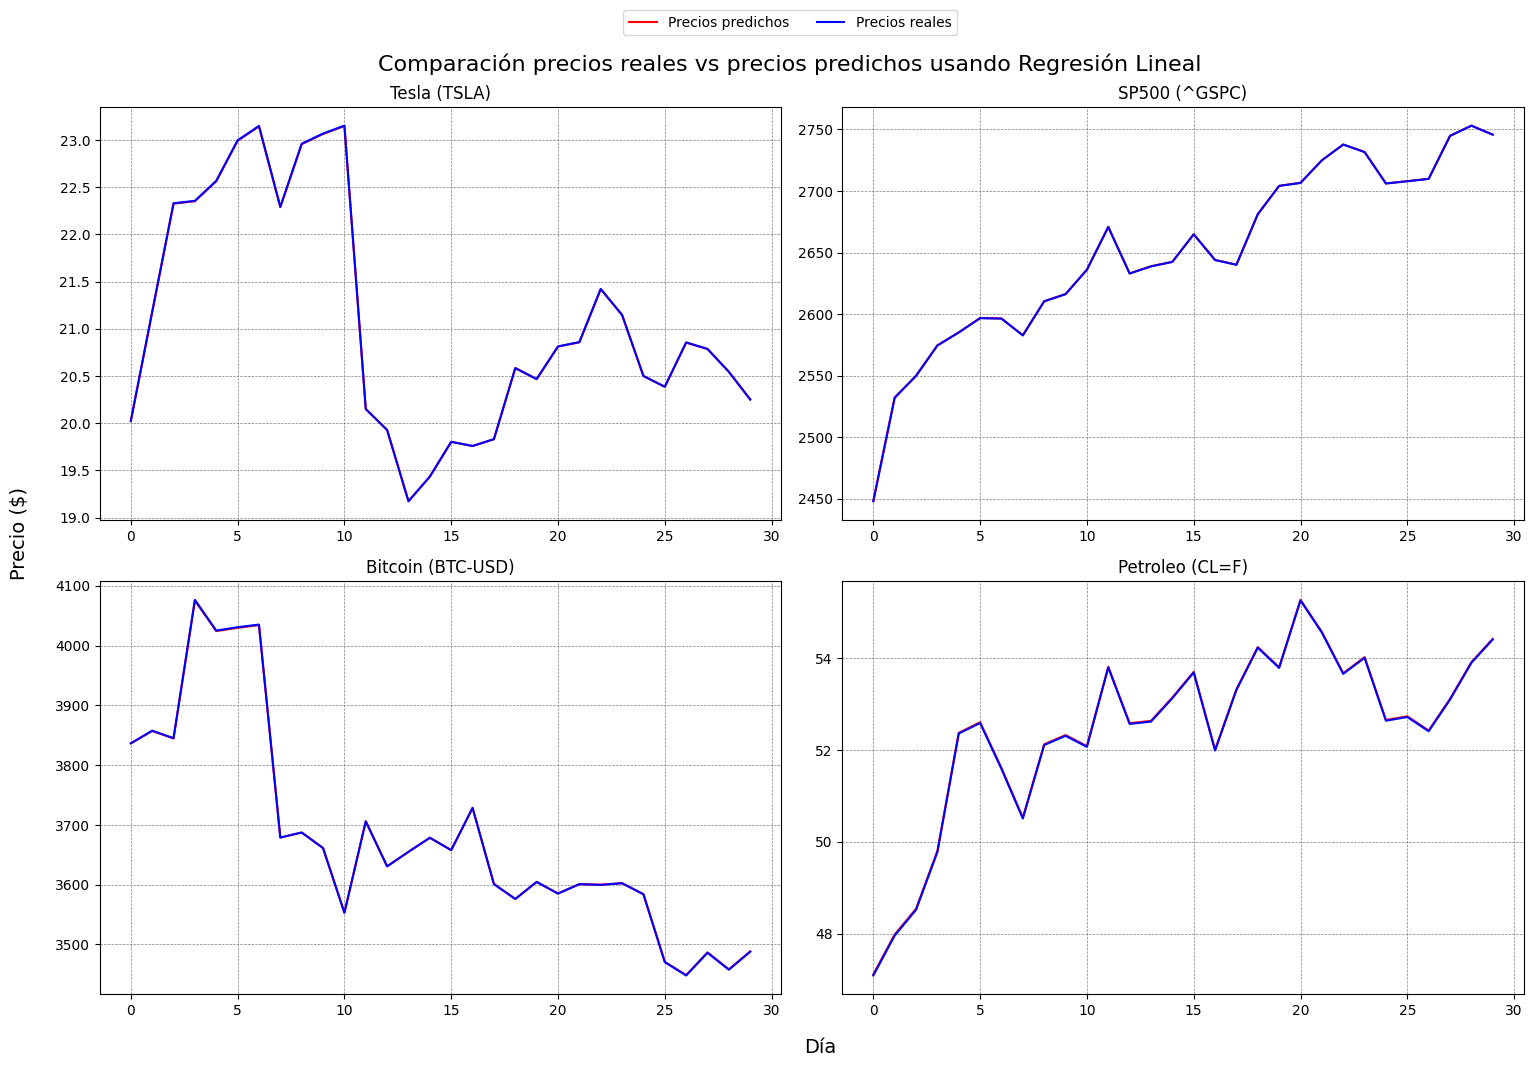

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_lr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_lr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_lr_bitcoin.predict(x_bitcoin_t_reg) 
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_lr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando Regresión Lineal', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 10 días

Tesla (TSLA)
RMSE:  1.8812631202999033
MSE:  3.539150927800528
MAE:  1.75925899573236
R²:  -110669.78895415484


SP500 (^GSPC)
RMSE:  74.36358568314398
MSE:  5529.942875654297
MAE:  70.33234112710306
R²:  -14377.170389048517


Bitcoin (BTC-USD)
RMSE:  166.20762756966735
MSE:  27624.97546233725
MAE:  147.997297023157
R²:  -6944.161818561093


Petroleo (CL=F)
RMSE:  4.2407306488890315
MSE:  17.983796436426786
MAE:  3.8037525432714125
R²:  -3469.8040286022906




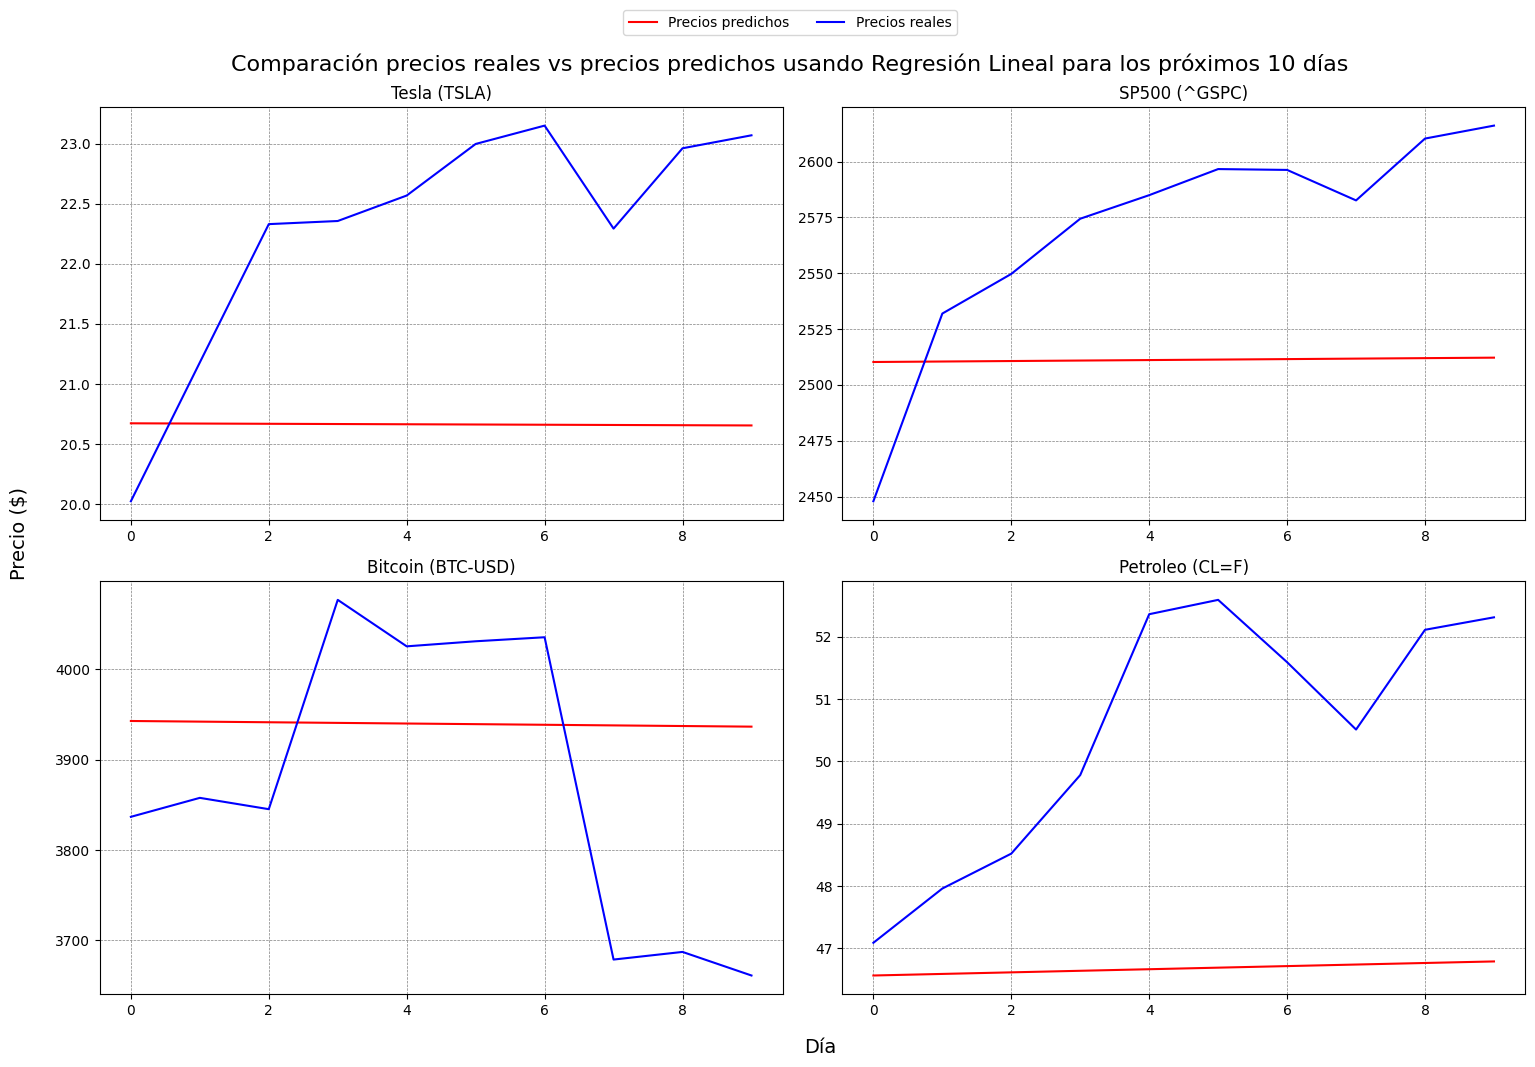

In [29]:
ventana = pasos
dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t[0:dias], y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t[0:dias], y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:ventana], ventana, dias, model_lr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t[0:dias], y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t[0:dias], y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando Regresión Lineal para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

## SVR

Volvemos a preparar los datos ya que este modelo empelará una ventana diferente:

In [36]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 10
pasos_sp500 = 5
pasos_bitcoin = 10
pasos_petroleo = 10

y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)


In [31]:
param_grid = {'C': [1, 10, 100, 200, 300, 500, 600, 800, 1000, 1500, 2000, 3500, 4000, 4500, 10000, 20000, 30000, 40000, 50000, 60000, 61000], 
              'gamma': [1, 0.1, 0.2, 0.4, 0.8, 0.001,0.002,0.004,0.006, 0.0008, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000018, 0.000019], 
              'kernel': ['linear', 'rbf']}

model_svr_tesla = SVR()
grid_search = GridSearchCV(model_svr_tesla, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_tesla_reg, np.ravel(y_train_tesla))
model_svr_tesla = grid_search.best_estimator_
best_params_tesla_svr = grid_search.best_params_

print("Mejores parámetros para Tesla: ", grid_search.best_params_)
print("Mejor resultado para Tesla: ", grid_search.best_score_)


model_svr_sp500 = SVR()
grid_search = GridSearchCV(model_svr_sp500, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_sp500_reg, np.ravel(y_train_sp500))
model_svr_sp500 = grid_search.best_estimator_
best_params_sp500_svr = grid_search.best_params_

print("Mejores parámetros para SP500: ", grid_search.best_params_)
print("Mejor resultado para SP500: ", grid_search.best_score_)


model_svr_bitcoin = SVR()
grid_search = GridSearchCV(model_svr_bitcoin, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_bitcoin_reg, np.ravel(y_train_bitcoin))
model_svr_bitcoin = grid_search.best_estimator_
best_params_btc_svr = grid_search.best_params_

print("Mejores parámetros para Bitcoin: ", grid_search.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search.best_score_)


model_svr_petroleo = SVR()
grid_search = GridSearchCV(model_svr_petroleo, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_petroleo_reg, np.ravel(y_train_petroleo))
model_svr_petroleo = grid_search.best_estimator_
best_params_petroleo_svr = grid_search.best_params_

print("Mejores parámetros para Petróleo: ", grid_search.best_params_)
print("Mejor resultado para Petróleo: ", grid_search.best_score_)

Mejores parámetros para Tesla:  {'C': 10000, 'gamma': 0.0008, 'kernel': 'rbf'}
Mejor resultado para Tesla:  0.9818347472639225
Mejores parámetros para SP500:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Mejor resultado para SP500:  0.9880465795640191
Mejores parámetros para Bitcoin:  {'C': 1500, 'gamma': 0.001, 'kernel': 'rbf'}
Mejor resultado para Bitcoin:  0.9034927649216694
Mejores parámetros para Petróleo:  {'C': 300, 'gamma': 0.006, 'kernel': 'rbf'}
Mejor resultado para Petróleo:  0.9873608518630839


Tesla (TSLA)
RMSE:  0.7712390769862522
MSE:  0.5948097138706062
MAE:  0.6115540590555422
R²:  0.6874955224217825


SP500 (^GSPC)
RMSE:  103.1703417491178
MSE:  10644.119416629757
MAE:  84.87653787388751
R²:  -4.855559165071049


Bitcoin (BTC-USD)
RMSE:  852.6888785413606
MSE:  727078.3235881233
MAE:  844.1357484115122
R²:  -0.9448378986005499


Petroleo (CL=F)
RMSE:  1.2017377636610806
MSE:  1.4441736526091355
MAE:  0.9691195921790631
R²:  0.9081571571464091




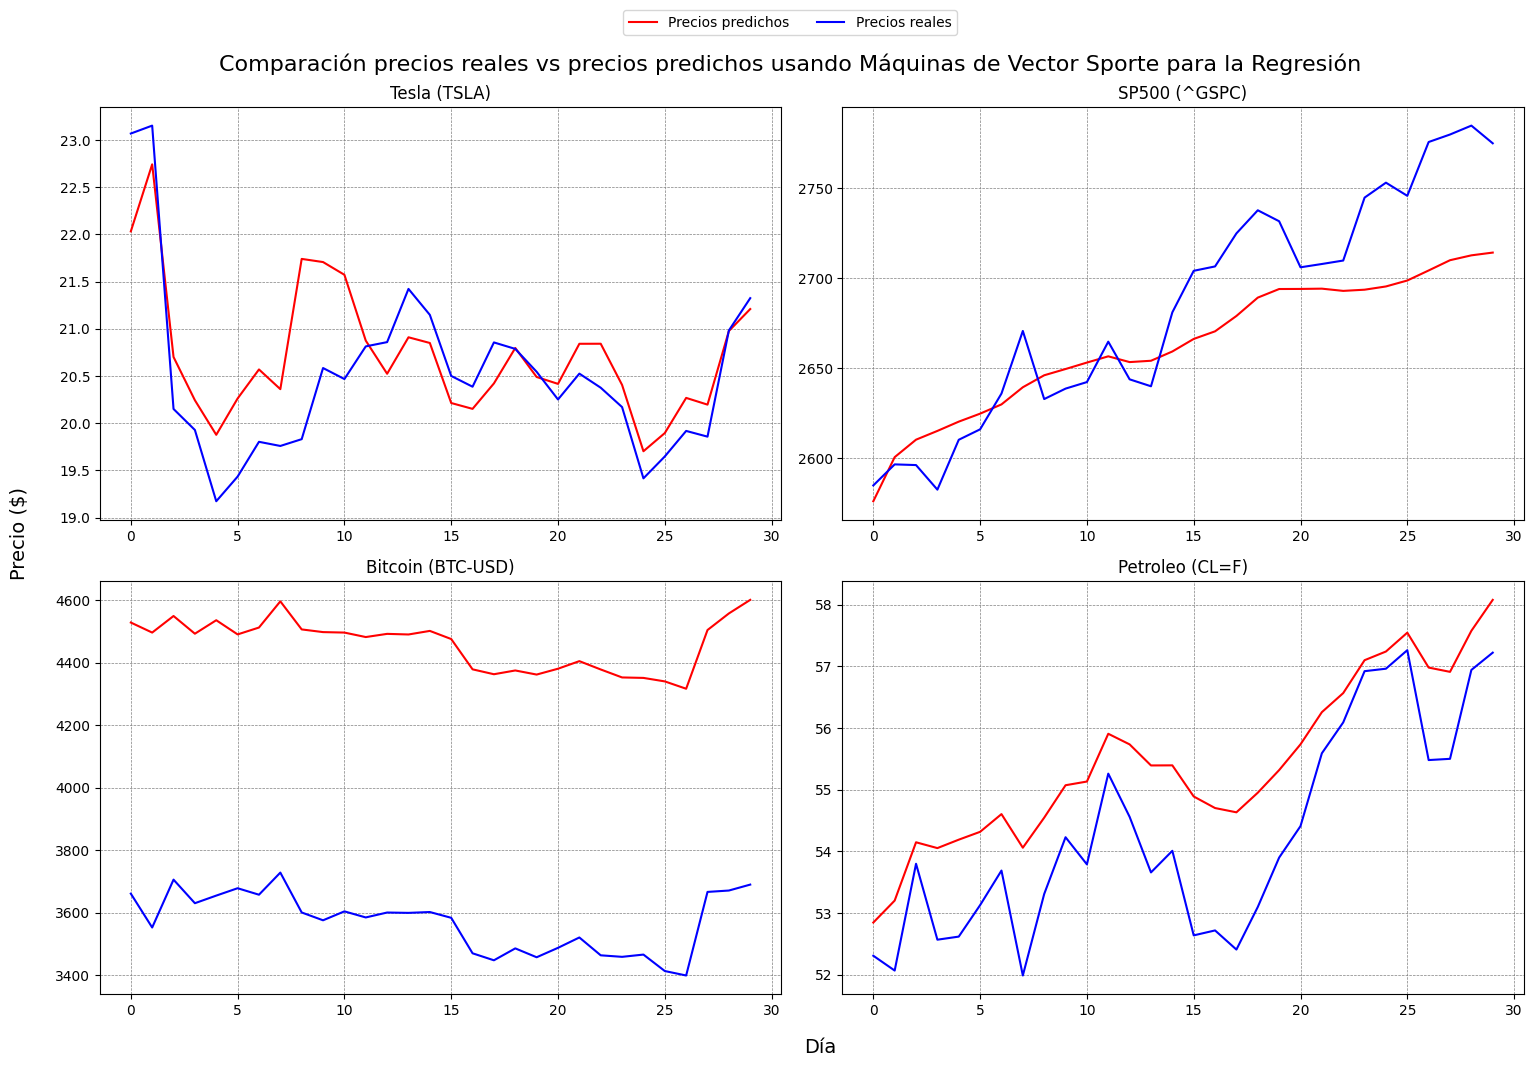

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_svr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_svr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_svr_bitcoin.predict(x_bitcoin_t_reg)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_svr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando Máquinas de Vector Sporte para la Regresión', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

### Predicción de los siguientes 10 días

Tesla (TSLA)
RMSE:  2.2455865833663795
MSE:  5.04265910339509
MAE:  2.1256659812225553
R²:  -7.356444708082371


SP500 (^GSPC)
RMSE:  17.68222140090174
MSE:  312.66095367050747
MAE:  12.579050488179382
R²:  0.48490856764410206


Bitcoin (BTC-USD)
RMSE:  4288.7575191205215
MSE:  18393441.057812814
MAE:  3851.689684921589
R²:  -4.198870549294382


Petroleo (CL=F)
RMSE:  2.2199499581260187
MSE:  4.928177816583712
MAE:  1.8750099387421835
R²:  -1.3497837483348887




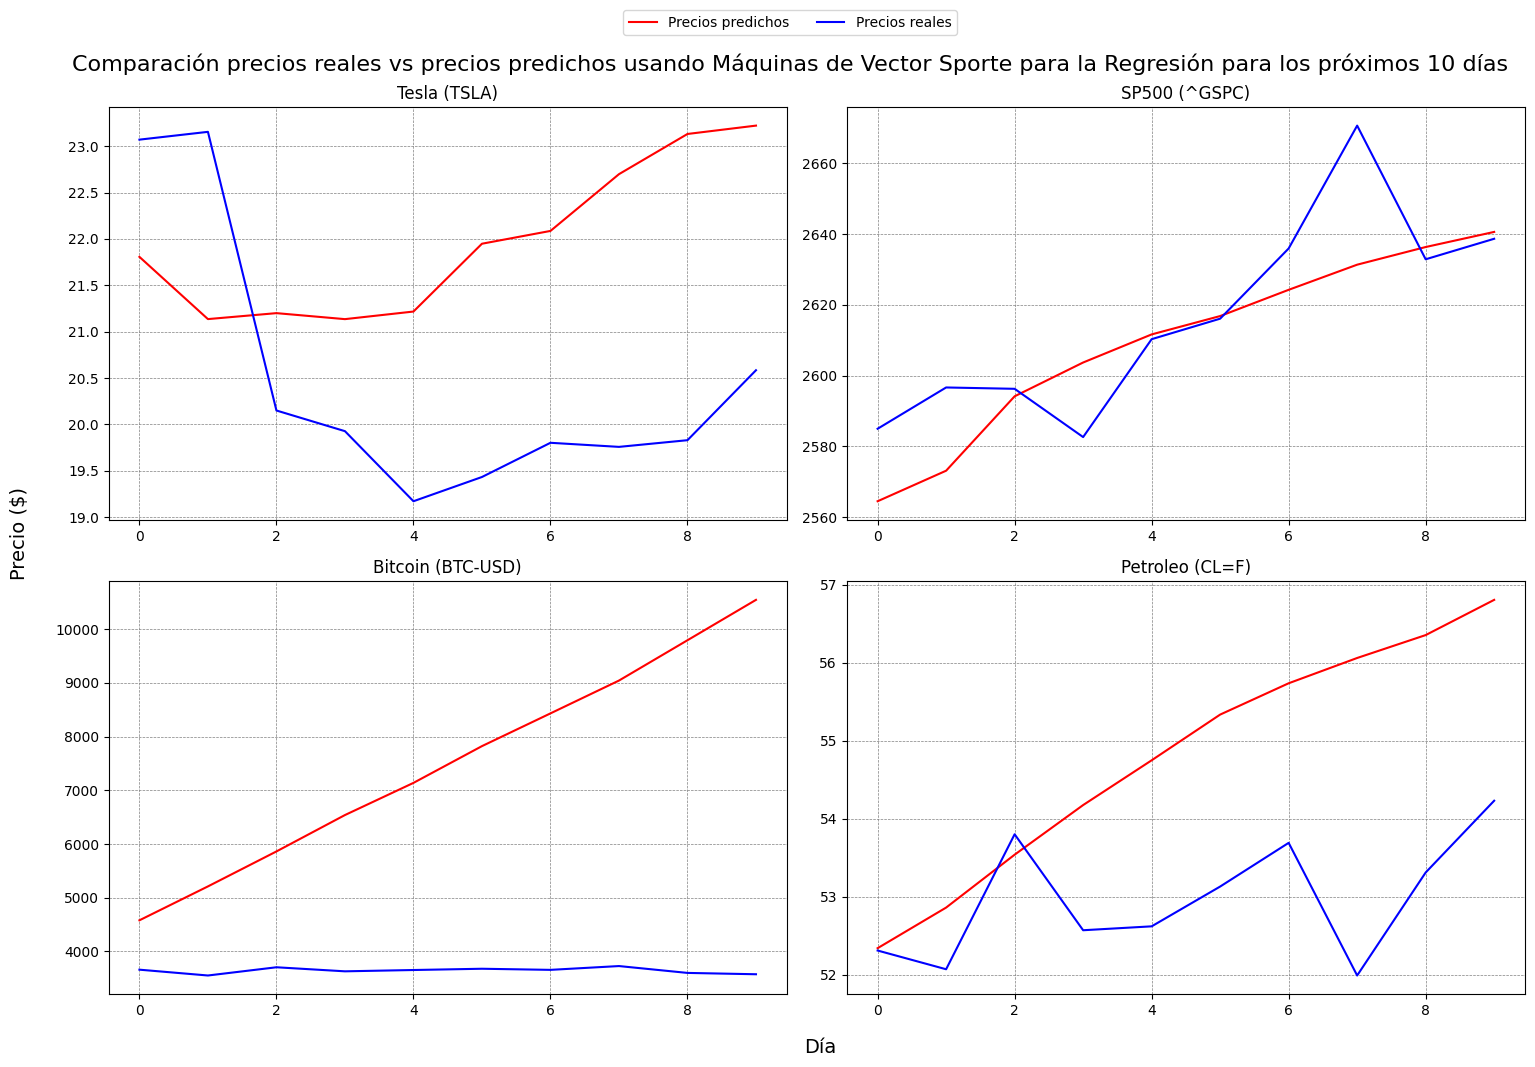

In [41]:
dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, model_svr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando Máquinas de Vector Sporte para la Regresión para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM

Preparamos los datos de entrenamiento

In [13]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [ ]:
def create_lstm(units, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mean_squared_error'])
    return model


lstm_tesla = KerasRegressor(build_fn=create_lstm)
lstm_sp500 = KerasRegressor(build_fn=create_lstm)
lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
lstm_petroleo = KerasRegressor(build_fn=create_lstm)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]
}

grid_search_tesla = GridSearchCV(estimator=lstm_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=lstm_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=lstm_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=lstm_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)


In [38]:
print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)

Mejores parámetros para Tesla:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 256}
Mejor resultado para Tesla:  0.9739037825177705
Mejores parámetros para SP500:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 512}
Mejor resultado para SP500:  0.9893025528528371
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'learning_rate': 0.01, 'units': 24}
Mejor resultado para Bitcoin:  0.9094861034779459
Mejores parámetros para Petróleo:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 512}
Mejor resultado para Petróleo:  0.9674798045746383


2/2 [==============================] - 0s 18ms/step
Tesla (TSLA)
RMSE:  0.5423793835611935
MSE:  0.29417539571222034
MAE:  0.40725818047156703
R²:  0.7845438471886189


2/2 [==============================] - 0s 11ms/step
SP500 (^GSPC)
RMSE:  25.784152474224715
MSE:  664.8225188140685
MAE:  22.424842247596153
R²:  0.7945480000962439


3/3 [==============================] - 0s 26ms/step
Bitcoin (BTC-USD)
RMSE:  131.4648356789056
MSE:  17283.003020081647
MAE:  82.00897011060395
R²:  0.9579326076499411


2/2 [==============================] - 0s 6ms/step
Petroleo (CL=F)
RMSE:  0.8101140403132469
MSE:  0.6562847583126529
MAE:  0.6618242263793953
R²:  0.9455440003318211




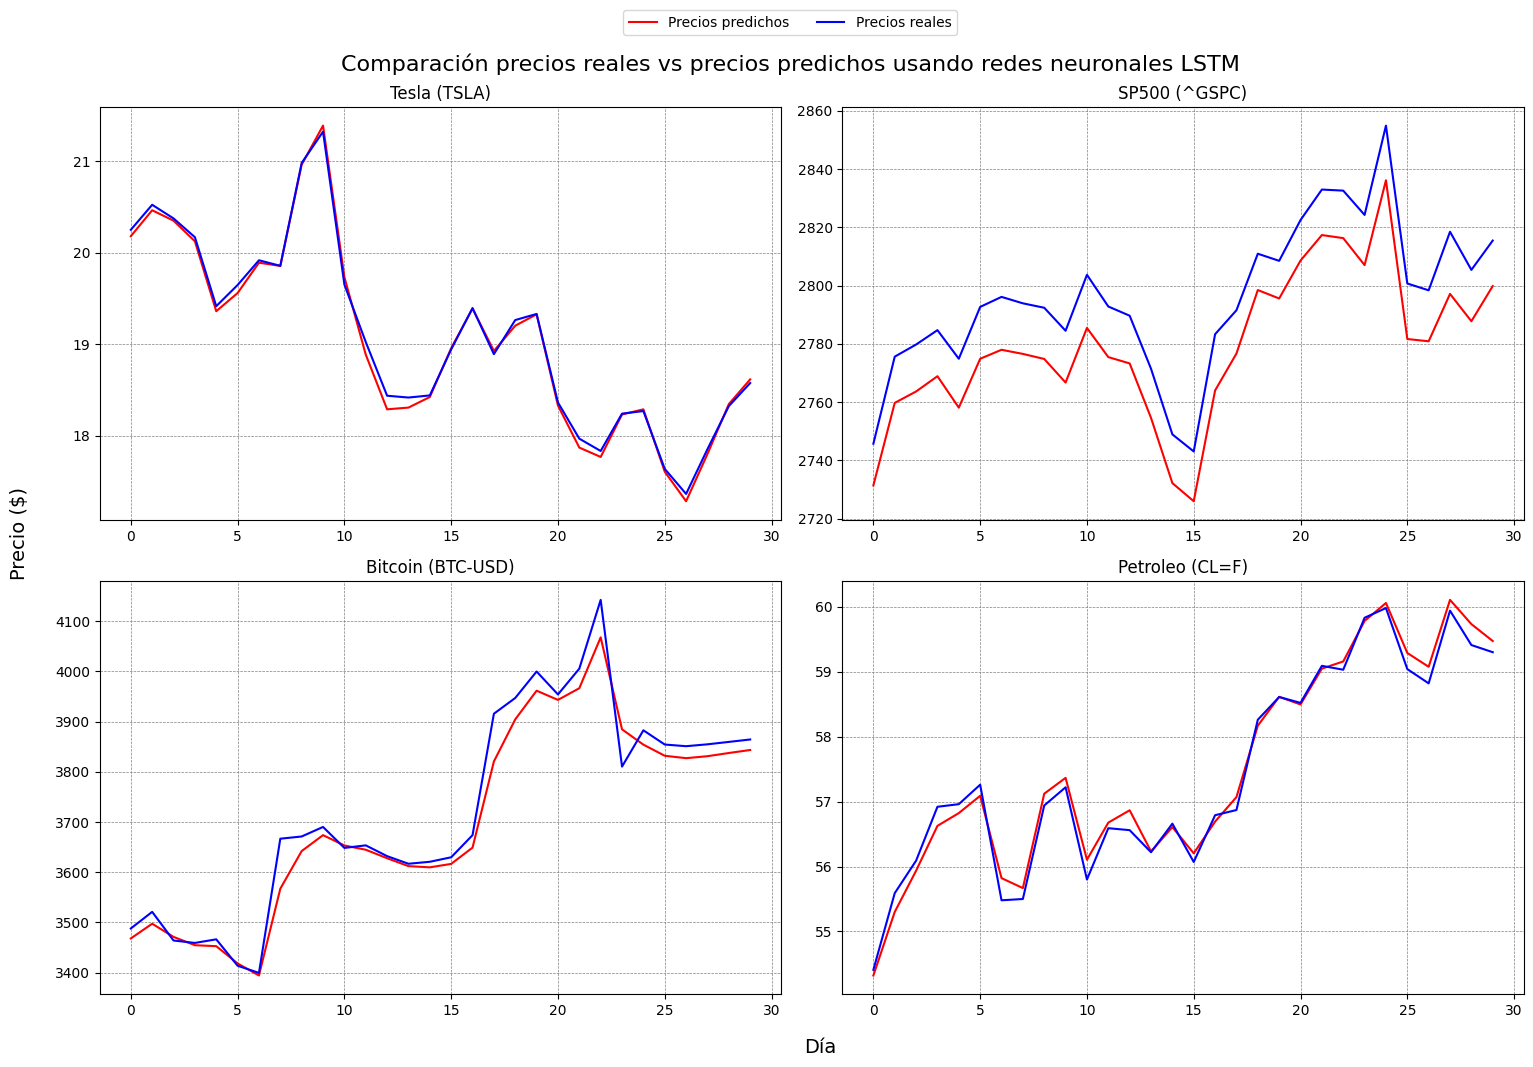

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = Sequential()
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_tesla.add(Dense(units = 1))

lstm_tesla.compile(optimizer=Adam(learning_rate=grid_search_tesla.best_params_['learning_rate']), loss = 'mean_squared_error')
history = lstm_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_tesla, 'modelos/lstm_tesla.h5')


lstm_sp500 = Sequential()
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_sp500.add(Dense(units = 1))
lstm_sp500.compile(optimizer=Adam(learning_rate=grid_search_sp500.best_params_['learning_rate']), loss='mean_squared_error')
history = lstm_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_sp500, 'modelos/lstm_sp500.h5')


lstm_bitcoin = Sequential()
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_bitcoin.add(Dense(units = 1))
lstm_bitcoin.compile(optimizer=Adam(learning_rate=grid_search_bitcoin.best_params_['learning_rate']), loss='mean_squared_error')
history = lstm_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_bitcoin, 'modelos/stm_bitcoin.h5')


lstm_petroleo = Sequential()
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_petroleo.add(Dense(units = 1))
lstm_petroleo.compile(optimizer=Adam(learning_rate=grid_search_petroleo.best_params_['learning_rate']), loss='mean_squared_error')
history = lstm_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_petroleo, 'modelos/lstm_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

### Predicción de los siguientes 10 días

Tesla (TSLA)
RMSE:  1.8413327670174564
MSE:  3.390506358892162
MAE:  1.657283401489258
R²:  -12.638309851760122


SP500 (^GSPC)
RMSE:  71.730109102066
MSE:  5145.2085517942905
MAE:  70.5622802734375
R²:  -8.339055157298926


Bitcoin (BTC-USD)
RMSE:  355.40389159725777
MSE:  126311.92616247537
MAE:  344.16369628906256
R²:  -66.11966645904694


Petroleo (CL=F)
RMSE:  6.320205623592903
MSE:  39.94499912449536
MAE:  6.1755741119384755
R²:  -14.857015343129886




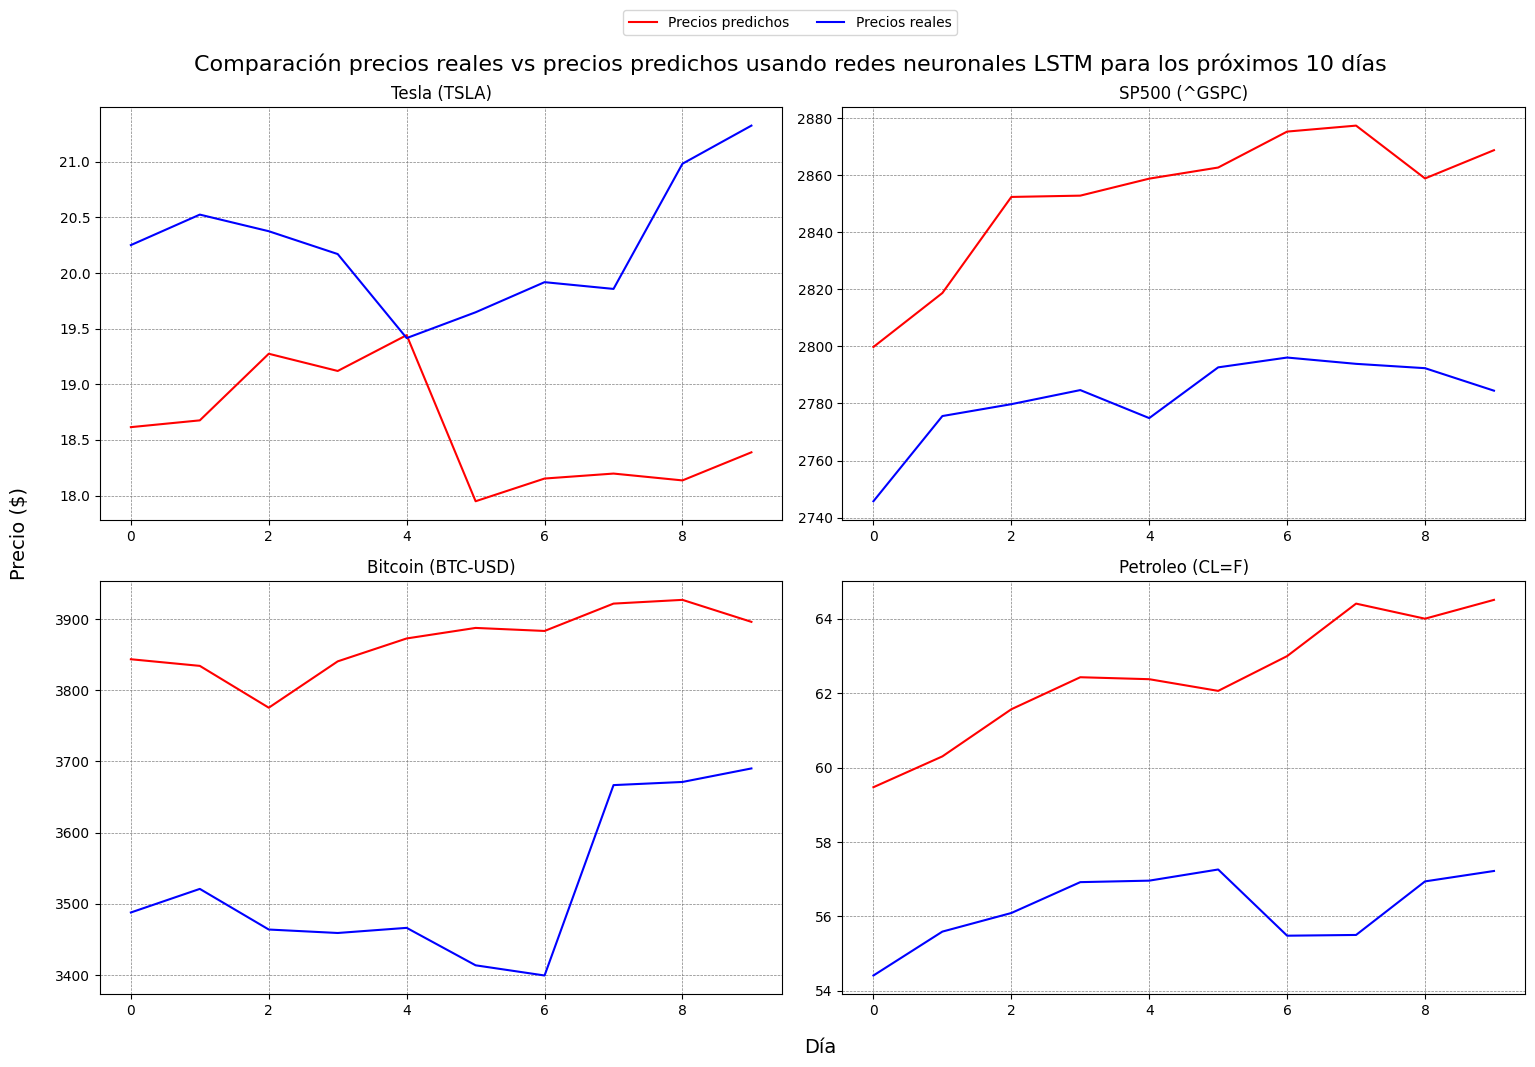

In [17]:
dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# GRU

In [27]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

In [ ]:
def create_gru(units, activation, learning_rate):
    model = Sequential()
    model.add(GRU(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_squared_error'])
    return model

gru_tesla = KerasRegressor(build_fn=create_gru)
gru_sp500 = KerasRegressor(build_fn=create_gru)
gru_bitcoin = KerasRegressor(build_fn=create_gru)
gru_petroleo = KerasRegressor(build_fn=create_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]
}

grid_search_tesla = GridSearchCV(estimator=gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)


In [40]:
print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)

Mejores parámetros para Tesla:  {'activation': 'relu', 'learning_rate': 0.01, 'units': 64}
Mejor resultado para Tesla:  0.9921747122933952
Mejores parámetros para SP500:  {'activation': 'relu', 'learning_rate': 0.01, 'units': 36}
Mejor resultado para SP500:  0.9966093150173894
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 512}
Mejor resultado para Bitcoin:  0.9804708113358185
Mejores parámetros para Petróleo:  {'activation': 'relu', 'learning_rate': 0.01, 'units': 36}
Mejor resultado para Petróleo:  0.9896082424862428


2/2 [==============================] - 0s 33ms/step
Tesla (TSLA)
RMSE:  0.6751216072639472
MSE:  0.45578918459465545
MAE:  0.5039232143988976
R²:  0.6600363578202624


2/2 [==============================] - 0s 10ms/step
SP500 (^GSPC)
RMSE:  17.49268018836844
MSE:  305.99386017253767
MAE:  13.167062612680288
R²:  0.9061539455037902


3/3 [==============================] - 0s 13ms/step
Bitcoin (BTC-USD)
RMSE:  703.705664427222
MSE:  495201.66214695806
MAE:  692.9623474806882
R²:  -0.32562747564669925


2/2 [==============================] - 0s 15ms/step
Petroleo (CL=F)
RMSE:  0.9473268862577655
MSE:  0.8974282294268333
MAE:  0.77620293543889
R²:  0.9298243697007261




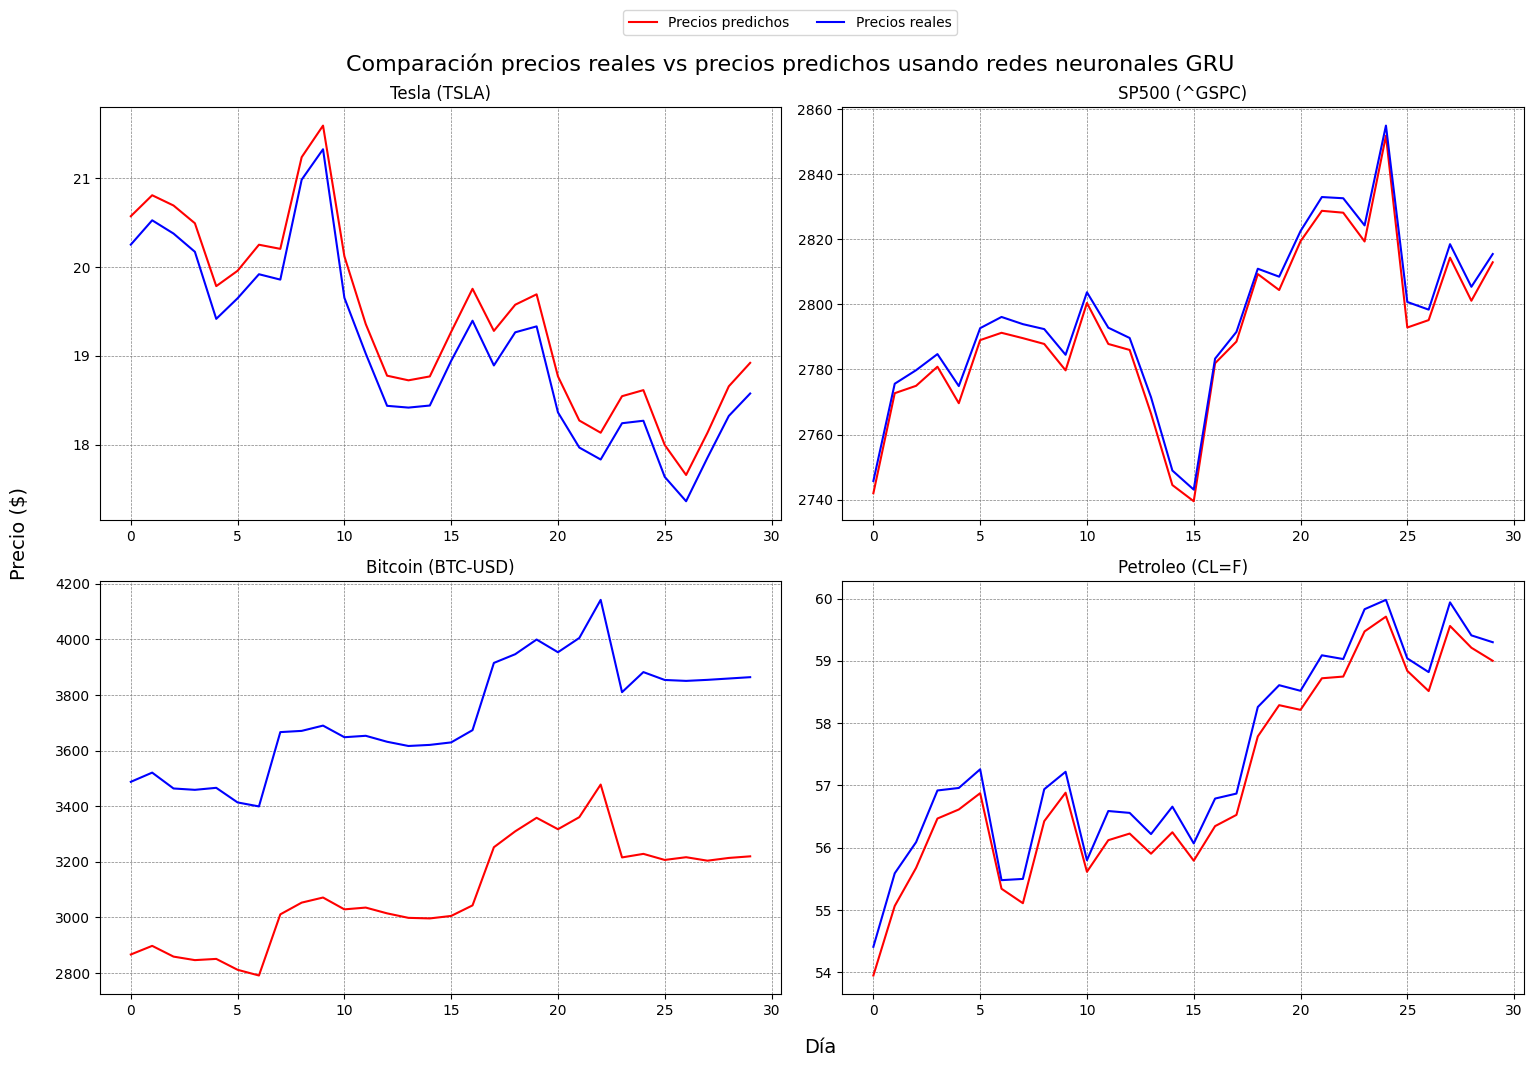

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = Sequential()
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
gru_tesla.add(Dense(units = 1))

gru_tesla.compile(optimizer=Adam(learning_rate=grid_search_tesla.best_params_['learning_rate']), loss = 'mean_squared_error')
history = gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(gru_tesla, 'modelos/gru_tesla.h5')


gru_sp500 = Sequential()
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_sp500.add(Dense(units = 1))
gru_sp500.compile(optimizer=Adam(learning_rate=grid_search_sp500.best_params_['learning_rate']), loss='mean_squared_error')
history = gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(gru_sp500, 'modelos/gru_sp500.h5')


gru_bitcoin = Sequential()
gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
gru_bitcoin.add(Dense(units = 1))
gru_bitcoin.compile(optimizer=Adam(learning_rate=grid_search_bitcoin.best_params_['learning_rate']), loss='mean_squared_error')
history = gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(gru_bitcoin, 'modelos/gru_bitcoin.h5')


gru_petroleo = Sequential()
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
gru_petroleo.add(Dense(units = 1))
gru_petroleo.compile(optimizer=Adam(learning_rate=grid_search_petroleo.best_params_['learning_rate']), loss='mean_squared_error')
history = gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(gru_petroleo, 'modelos/gru_petroleo.h5')

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

### Predicción de los siguientes 10 días

Tesla (TSLA)
RMSE:  1.794470971194635
MSE:  3.220126066460216
MAE:  1.6422630310058595
R²:  -7.440638550370881


SP500 (^GSPC)
RMSE:  56.00310598167359
MSE:  3136.3478795945643
MAE:  51.4521240234375
R²:  -23.861151729070123


Bitcoin (BTC-USD)
RMSE:  1353.9830227562738
MSE:  1833270.0259122164
MAE:  1310.4199951171875
R²:  -21.95597121887037


Petroleo (CL=F)
RMSE:  4.582976230646617
MSE:  21.00367113067187
MAE:  4.294228363037111
R²:  -24.385815708766497




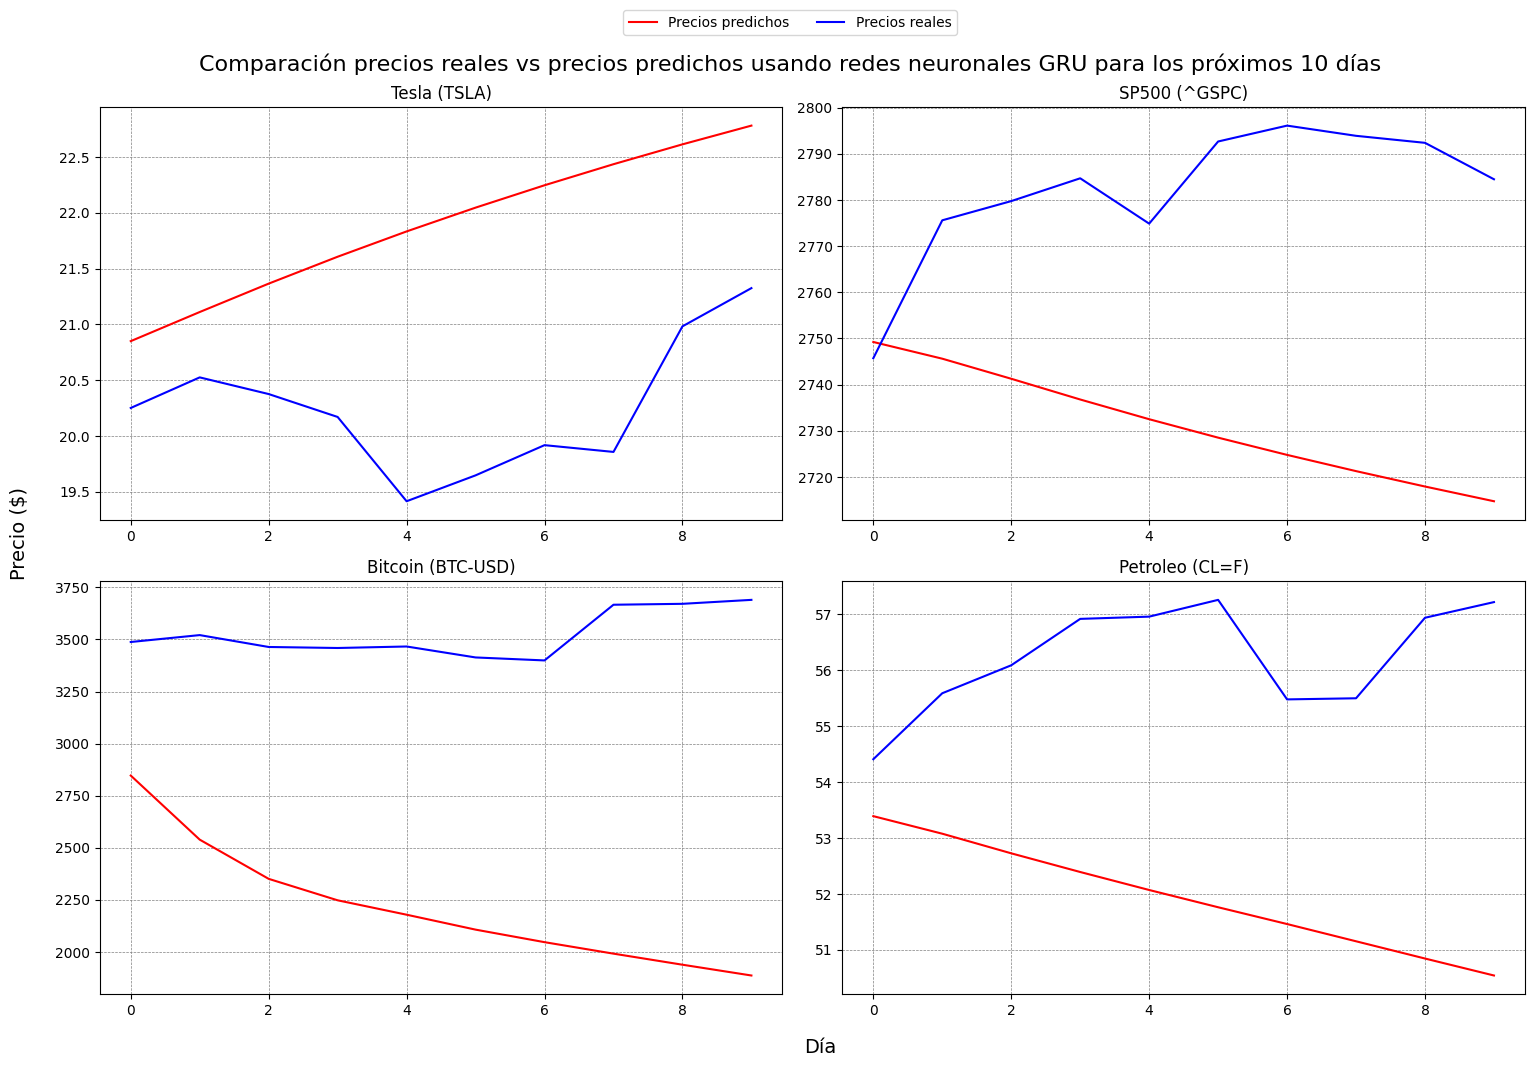

In [19]:
dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM + GRU

In [31]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [ ]:
def create_lstm_gru(units, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_squared_error'])
    return model


lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_petroleo = KerasRegressor(build_fn=create_lstm_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]
}


grid_search_tesla = GridSearchCV(estimator=lstm_gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_sp500 = GridSearchCV(estimator=lstm_gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_bitcoin = GridSearchCV(estimator=lstm_gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_petroleo = GridSearchCV(estimator=lstm_gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=1)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

In [34]:
print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)

Mejores parámetros para Tesla:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 256}
Mejor resultado para Tesla:  0.9788598901097728
Mejores parámetros para SP500:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 256}
Mejor resultado para SP500:  0.9905079368210054
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 256}
Mejor resultado para Bitcoin:  0.926425021203587
Mejores parámetros para Petróleo:  {'activation': 'relu', 'learning_rate': 0.001, 'units': 256}
Mejor resultado para Petróleo:  0.9623907173244598


2/2 [==============================] - 0s 8ms/step
Tesla (TSLA)
RMSE:  0.647956534377984
MSE:  0.41984767044312743
MAE:  0.47578855661245495
R²:  0.6944832555219975


2/2 [==============================] - 0s 21ms/step
SP500 (^GSPC)
RMSE:  17.290141889719543
MSE:  298.9490065666345
MAE:  13.534423828125
R²:  0.912305185369057


3/3 [==============================] - 0s 14ms/step
Bitcoin (BTC-USD)
RMSE:  115.86021986811734
MSE:  13423.59054788849
MAE:  63.52988390976127
R²:  0.969393409102219


2/2 [==============================] - 0s 14ms/step
Petroleo (CL=F)
RMSE:  0.8326814686162036
MSE:  0.6933584281768377
MAE:  0.6604444063626809
R²:  0.9441213854179104




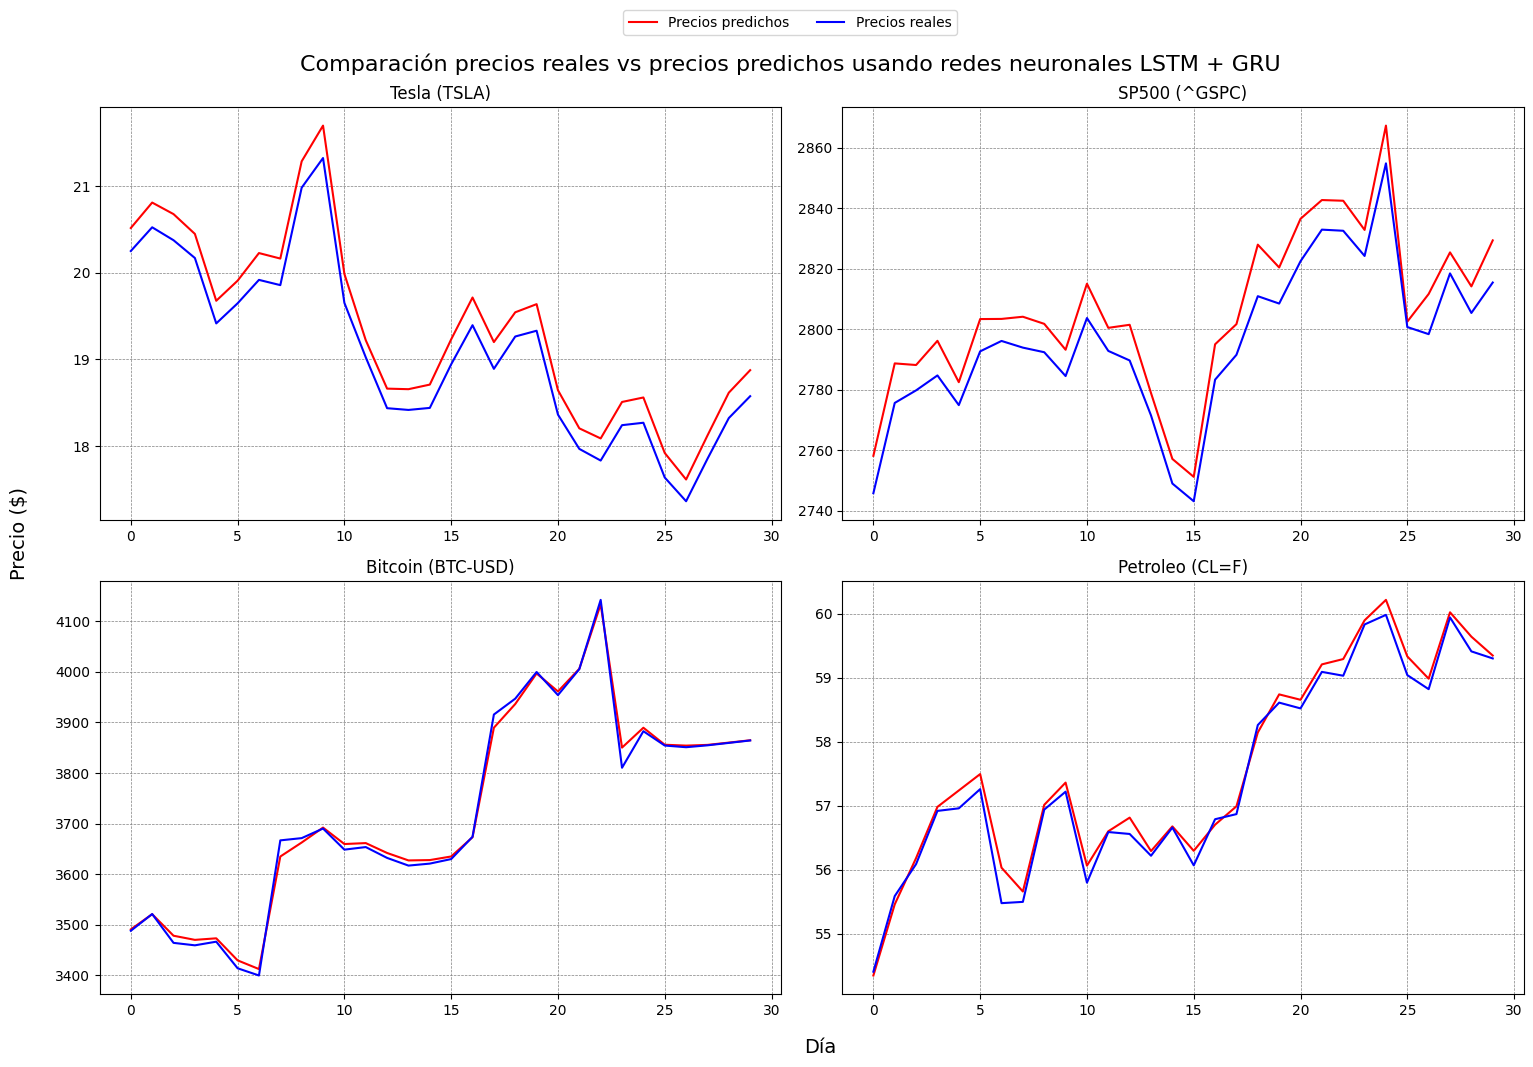

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = Sequential()
lstm_gru_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_gru_tesla.add(Dense(units = 1))
lstm_gru_tesla.compile(optimizer=Adam(learning_rate=grid_search_tesla.best_params_['learning_rate']), loss = 'mean_squared_error')
history = lstm_gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_gru_tesla, 'modelos/lstm_gru_tesla.h5')

lstm_gru_sp500 = Sequential()
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_gru_sp500.add(Dense(units = 1))
lstm_gru_sp500.compile(optimizer=Adam(learning_rate=grid_search_sp500.best_params_['learning_rate']), loss='mean_squared_error')
history = lstm_gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_gru_sp500, 'modelos/lstm_gru_sp500.h5')

lstm_gru_bitcoin = Sequential()
lstm_gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_gru_bitcoin.add(Dense(units = 1))
lstm_gru_bitcoin.compile(optimizer=Adam(learning_rate=grid_search_bitcoin.best_params_['learning_rate']), loss='mean_squared_error')
history = lstm_gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_gru_bitcoin, 'modelos/lstm_gru_bitcoin.h5')


lstm_gru_petroleo = Sequential()
lstm_gru_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_gru_petroleo.add(Dense(units = 1))
lstm_gru_petroleo.compile(optimizer=Adam(learning_rate=grid_search_petroleo.best_params_['learning_rate']), loss='mean_squared_error')
history = lstm_gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_gru_petroleo, 'modelos/lstm_gru_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

### Predicción de los siguientes 10 días

Tesla (TSLA)
RMSE:  2.1967839094706068
MSE:  4.825859544908963
MAE:  1.9947027206420898
R²:  -4.744559233139018


SP500 (^GSPC)
RMSE:  37.47690281970915
MSE:  1404.5182449579238
MAE:  30.33349609375
R²:  -0.5107123788489285


Bitcoin (BTC-USD)
RMSE:  100.19628416257264
MSE:  10039.295359987005
MAE:  80.25339355468745
R²:  -33.853558931061485


Petroleo (CL=F)
RMSE:  2.423141372369799
MSE:  5.871614110490195
MAE:  2.2644226074218765
R²:  -330.51450240480705




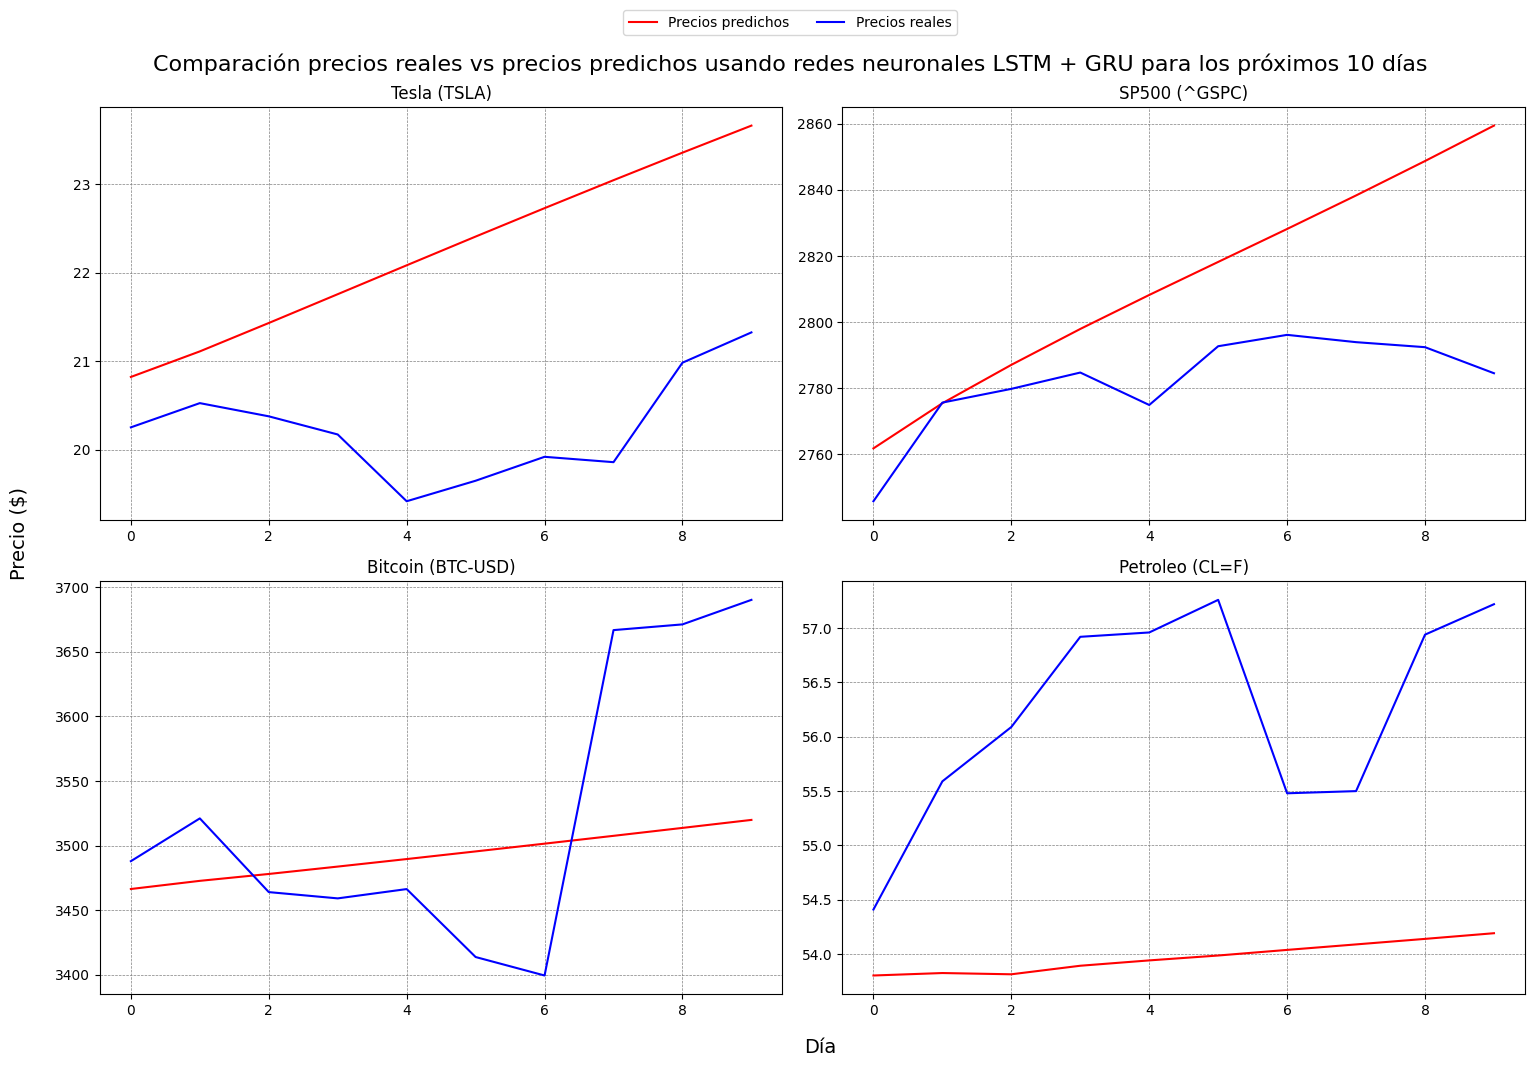

In [23]:
dias = 10

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 10 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()